In [111]:
%pip install langchain-core langgraph>0.2.27 langchain langchain-openai langchain-community python-dotenv tavily-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
import getpass
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Define Execution Agent

In [113]:
# Import relevant functionality
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

# Create the agent
model = init_chat_model("gpt-4o-mini", model_provider="openai")
search = TavilySearchResults(max_results=3)
tools = [search]
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(model, tools, prompt=prompt)

Test execution agent

In [114]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='9b2dcd19-cf9b-48d0-bb29-5e9b734fbbf1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uZ33y1jlJkTqK10iRhmgNXyT', 'function': {'arguments': '{"query":"US Open winner 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 95, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BGvo8WpKCz8Vu1X8CXtXG3sIQPNTw', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a3485197-2eff-44f0-8a86-fedf179bd3c1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query':

## Define the State

First, we will need to track the current plan. Let's represent that as a list of strings.

Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.

In [115]:
import operator  # For basic operations like addition
from typing import Annotated, List, Tuple  # Type hints for complex data structures
from typing_extensions import TypedDict  # For creating typed dictionary classes


class PlanExecute(TypedDict):
    """TypedDict for Plan-Execute agent state management.
    
    This class defines the structure for tracking the state of a planning 
    and execution process in LangChain agents.
    """
    
    # The initial input/query from the user
    input: str
    
    # List of planned steps to accomplish the task
    plan: List[str]
    
    # Track completed steps, can be combined using operator.add
    past_steps: Annotated[List[Tuple], operator.add]
    
    # Final response or current state of execution
    response: str

## Planning Step

In [116]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


In [117]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

## Test planner

In [118]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year to determine which Australia Open winner to consider.', 'Look up the winner of the Australia Open for the current year.', 'Research the hometown of the identified winner from the Australia Open.'])

## Replan step

Create a step that re-does the plan based on the result of the previous step.

In [130]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If the plan is complete and no more steps are needed then respond with the answer that meets the original objective. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

## Create the Graph

In [ ]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    

    print("==EXECUTING=============================================")
    print(f"Executing step: {task}")
    print(f"Task formatted: {task_formatted}")
    print("========================================================")
    
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    print("==REPLANNING============================================")
    print(f"Current Plan: {state['plan']}")
    output = await replanner.ainvoke(state)
    print(f"Output: {output}")
    print("========================================================")

    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"
    

In [132]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

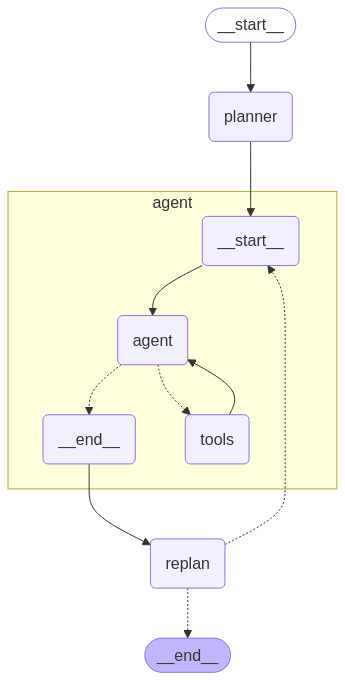

In [133]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [134]:
config = {"recursion_limit": 20}
inputs = {"input": "Create a set of Enterprise Architecture principles for the end-to-end AI Architecture of a large enterprise. Follow good practice for defining Architecture Principles and ensure the principles reflect the challenges of building Artificial Intelligent systems. The output should just be a list of EA Principles."}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the key challenges and requirements specific to AI systems in a large enterprise context, such as scalability, data privacy, and integration with existing systems.', 'Define a clear and concise title for each principle that reflects its core idea or objective.', 'For each principle, write a brief description that explains its purpose and importance in the context of AI architecture.', 'Ensure each principle includes a rationale that justifies why it is important and how it addresses specific challenges or requirements.', 'Include implications for each principle, detailing how it will affect decision-making, processes, and the overall architecture.', "Review the principles to ensure they are aligned with the enterprise's overall business goals and IT strategy.", 'Organize the principles in a logical order, starting with foundational principles and moving to more specific ones.', 'Finalize the list of principles, ensuring clarity, consistency, and completeness.']}
Exe